In [5]:
! pip install rasterio

# **Required Libraries**

In [6]:
import os
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K

**Paths**

In [7]:
IMAGES_PATH = "/kaggle/input/satellite-dataset/satalite data/data/images"
LABELS_PATH = "/kaggle/input/satellite-dataset/satalite data/data/labels"

In [8]:
image_files = sorted(os.listdir(IMAGES_PATH))
label_files = sorted(os.listdir(LABELS_PATH))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


# **Dimensions of the Image & the Label**

In [9]:
img_path = os.path.join(IMAGES_PATH, image_files[0])
with rasterio.open(img_path) as src:
    image = src.read()   # shape: (bands, H, W)

print("Image shape:", image.shape)

Image shape: (12, 128, 128)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


**Rasterio returns: (bands, height, width), But deep learning expects: (height, width, bands)**

In [10]:
# So Transpose
image = np.transpose(image, (1, 2, 0))
print("New shape:", image.shape)

New shape: (128, 128, 12)


In [11]:
label_path = os.path.join(LABELS_PATH, label_files[0])
label = np.array(Image.open(label_path))

print("Label shape:", label.shape)

Label shape: (128, 128)


In [12]:
label = np.expand_dims(label, axis=-1)
print("Label shape:", label.shape)

Label shape: (128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..4975].


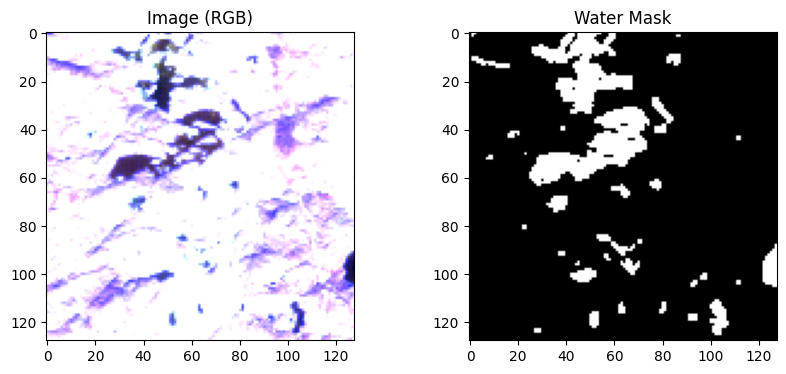

In [13]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image[:, :, 2:5])  # adjust band indices if needed (3 2 1) & data validation  leakage
plt.title("Image (RGB)")

plt.subplot(1,2,2)
plt.imshow(label.squeeze(), cmap="gray")
plt.title("Water Mask")

plt.show()

In [14]:
print("Image dtype:", image.dtype)
print("Label unique values:", np.unique(label))

Image dtype: int16
Label unique values: [0 1]


In [15]:
# NN receivers float not int
img = image.astype(np.float32)
print("Image dtype:", img.dtype)

Image dtype: float32


# **Normalization**

channel wise normalization 
min and max of each channel

In [16]:
# print(img.min())
# print(img.max())

In [17]:
# img = np.clip(img, 0, None)
# img = img / 10000.0

# print(img.min())
# print(img.max())

In [18]:
image_ids = set([f.split('.')[0] for f in image_files])
label_ids = set([f.split('.')[0] for f in label_files])

common_ids = sorted(list(image_ids.intersection(label_ids)))
print("Number of matching files:", len(common_ids))

Number of matching files: 306


In [19]:
matched_images = [f"{i}.tif" for i in common_ids]
matched_labels = [f"{i}.png" for i in common_ids]

len(matched_images) == len(matched_labels)

True

In [20]:
print("Images:", len(image_files))
print("Labels:", len(label_files))
print("Matched:", len(common_ids))

Images: 306
Labels: 456
Matched: 306


In [21]:
# X = []
# Y = []

# for img_file, lbl_file in zip(matched_images, matched_labels):

#     with rasterio.open(os.path.join(IMAGES_PATH, img_file)) as src:
#         img = src.read()
#         img = np.transpose(img, (1,2,0)).astype(np.float32)
#         img = np.clip(img, 0, None)
#         img = img / 10000.0

#     lbl = np.array(Image.open(os.path.join(LABELS_PATH, lbl_file)))
#     lbl = np.expand_dims(lbl, axis=-1).astype(np.float32)

#     X.append(img)
#     Y.append(lbl)

# X = np.array(X)
# Y = np.array(Y)

# print("X shape:", X.shape)
# print("Y shape:", Y.shape)

In [22]:
X = []
Y = []

for img_file, lbl_file in zip(matched_images, matched_labels):

    with rasterio.open(os.path.join(IMAGES_PATH, img_file)) as src:
        img = src.read()  # (bands, H, W)
        img = np.transpose(img, (1, 2, 0)).astype(np.float32)

    lbl = np.array(Image.open(os.path.join(LABELS_PATH, lbl_file)))
    lbl = np.expand_dims(lbl, axis=-1).astype(np.float32)

    X.append(img)
    Y.append(lbl)

X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


In [23]:
print("Water pixel ratio:", np.mean(Y))

Water pixel ratio: 0.25975287


Water pixel ratio ≈ 0.26  (26%)

This means:
- 26% of all pixels are water
- 74% are non-water

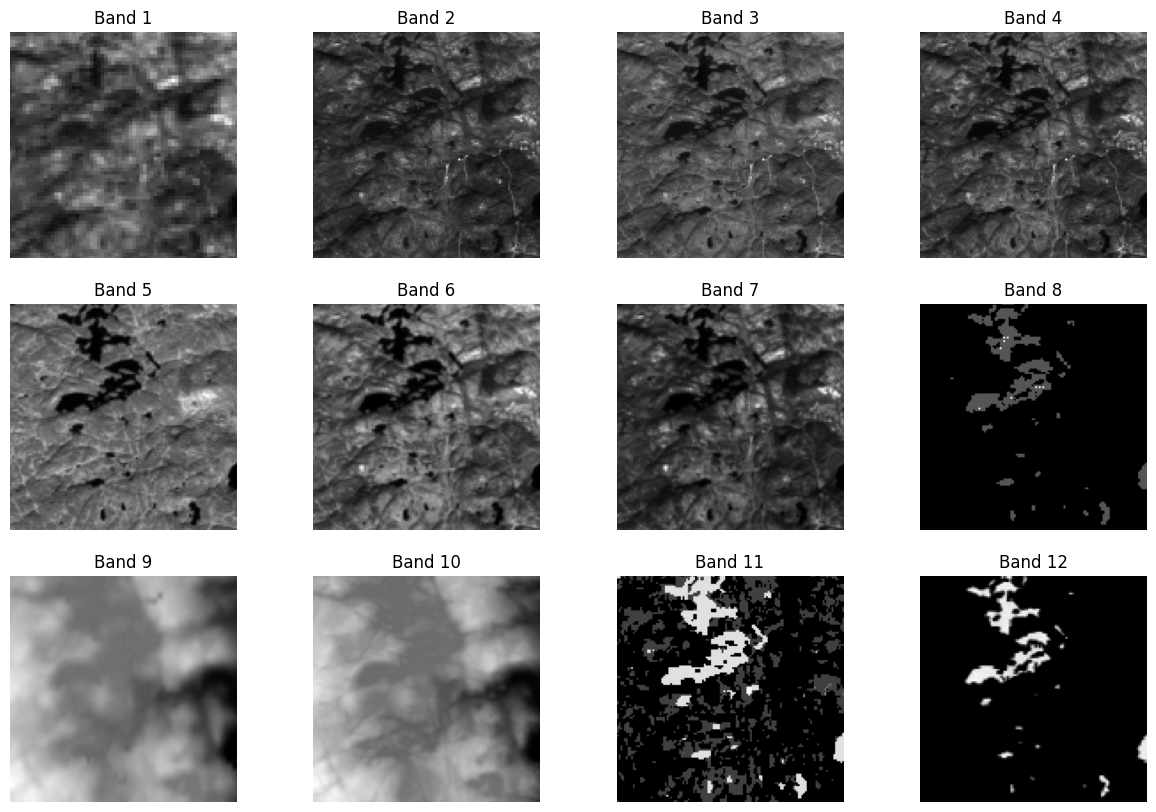

In [24]:
plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')
plt.show()

# **Model Architecture and Training**

In [25]:
# Train - Validation - Testing -> 80% - 10% - 10%
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(244, 128, 128, 12)
(31, 128, 128, 12)
(31, 128, 128, 12)


In [26]:
num_bands = X_train.shape[-1]

band_mins = np.zeros(num_bands)
band_maxs = np.zeros(num_bands)

for b in range(num_bands):
    band_mins[b] = np.min(X_train[..., b])
    band_maxs[b] = np.max(X_train[..., b])

print("Band mins:", band_mins)
print("Band maxs:", band_maxs)

Band mins: [-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.510e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Band maxs: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]


In [27]:
def normalize_per_band(X, band_mins, band_maxs):
    X_norm = np.zeros_like(X, dtype=np.float32)

    for b in range(X.shape[-1]):
        X_norm[..., b] = (
            (X[..., b] - band_mins[b]) /
            (band_maxs[b] - band_mins[b] + 1e-8)
        )

    return X_norm

In [28]:
X_train = normalize_per_band(X_train, band_mins, band_maxs)
X_val   = normalize_per_band(X_val, band_mins, band_maxs)
X_test  = normalize_per_band(X_test, band_mins, band_maxs)

print("After normalization:")
print("Train min/max:", X_train.min(), X_train.max())

After normalization:
Train min/max: 0.0 1.0


**Helping Functions**

In [29]:
def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + 1e-7) / (K.sum(y_true) + K.sum(y_pred) + 1e-7)

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# **U-Net Architecture From Scratch**

**Encoder**

In [30]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

**Decoder**

In [31]:
def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs) # Upsamples image (deconvolution)
    x = tf.keras.layers.Concatenate()([x, skip_features])

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

**U-Net Model**

In [32]:
def unet_model(input_shape=(128,128,12), num_classes=1):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder (Contracting path) → Extracts features and reduces spatial size
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck (8x8)
    b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(p4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Decoder (Expanding path) → Restores spatial size and predicts segmentation mask
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    return tf.keras.models.Model(inputs, outputs)

In [33]:
model = unet_model()
model.summary()

I0000 00:00:1771754579.284412      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,762,689 (29.61 MB)

 Trainable params: 7,762,689 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[iou_metric]
)

In [35]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=16
)

Epoch 1/100


I0000 00:00:1771754586.544808     142 service.cc:152] XLA service 0x7bebc0002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771754586.544847     142 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771754587.709719     142 cuda_dnn.cc:529] Loaded cuDNN version 91002


 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - iou_metric: 0.0047 - loss: 1.3519

I0000 00:00:1771754596.072642     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 807ms/step - iou_metric: 0.0328 - loss: 1.3481 - val_iou_metric: 0.3094 - val_loss: 1.3318
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - iou_metric: 0.3690 - loss: 1.3171 - val_iou_metric: 0.3504 - val_loss: 1.2546
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - iou_metric: 0.3548 - loss: 1.1872 - val_iou_metric: 0.4213 - val_loss: 0.9282
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - iou_metric: 0.5311 - loss: 0.8622 - val_iou_metric: 0.5181 - val_loss: 0.7501
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - iou_metric: 0.6032 - loss: 0.6752 - val_iou_metric: 0.5845 - val_loss: 0.6508
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - iou_metric: 0.6186 - loss: 0.6377 - val_iou_metric: 0.6529 - val_loss: 0.5977
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - iou_metric: 0.6354 - loss: 0.5963 - val_iou_metric: 0.5973 - val_loss: 0.6255
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - iou_metric: 0.6582 - loss: 0.560

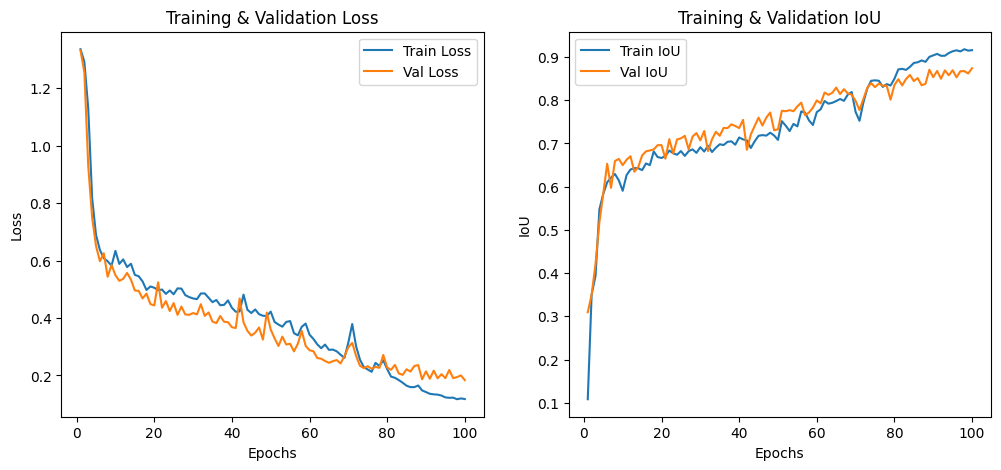

In [36]:
# Extract metrics
loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

epochs = range(1, len(loss) + 1)

# ---- Plot Loss ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])

# ---- Plot IoU ----
plt.subplot(1,2,2)
plt.plot(epochs, iou)
plt.plot(epochs, val_iou)
plt.title("Training & Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend(["Train IoU", "Val IoU"])

plt.show()

In [37]:
pred = model.predict(X_val[:1])
pred_mask = (pred > 0.5).astype("float32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


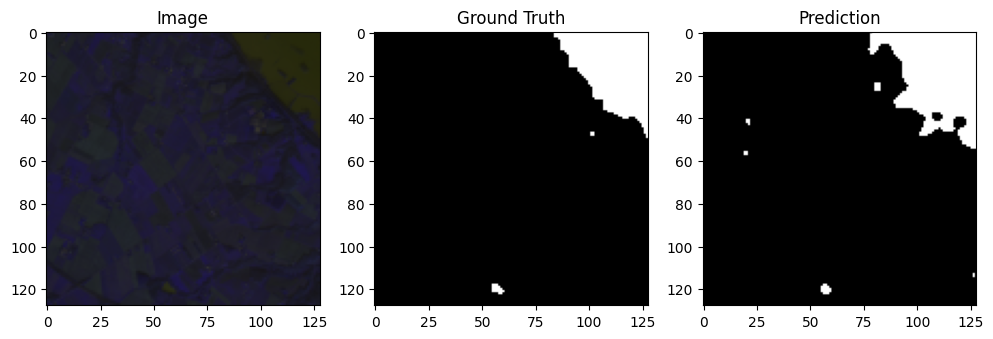

In [38]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_val[0][:,:,2:5])
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(Y_val[0].squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask[0].squeeze(), cmap='gray')
plt.title("Prediction")

plt.show()

In [39]:
results = model.evaluate(X_test, Y_test)
print("Test Loss:", results[0])
print("Test IoU:", results[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - iou_metric: 0.7996 - loss: 0.2951
Test Loss: 0.29506999254226685
Test IoU: 0.7995736002922058


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


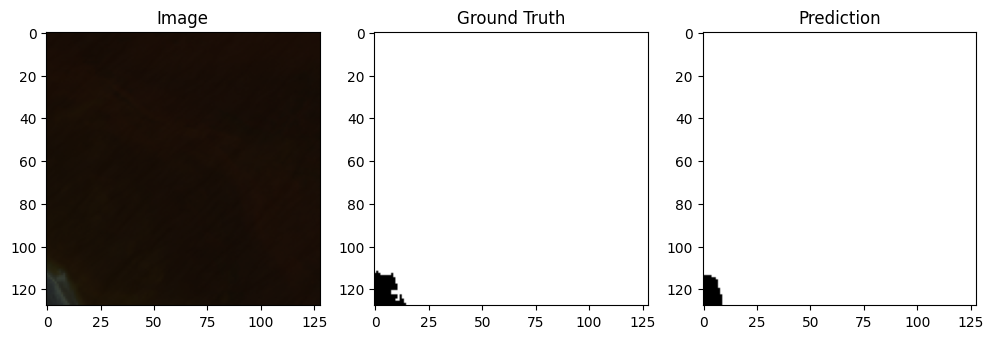

In [40]:
idx = np.random.randint(0, len(X_test))

pred = model.predict(X_test[idx:idx+1])
pred_mask = (pred > 0.5).astype("float32")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_test[idx][:,:,2:5])
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(Y_test[idx].squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask[0].squeeze(), cmap='gray')
plt.title("Prediction")

plt.show()